In [1]:
# import numpy as np
# import tensorflow as tf
# # import random as rn

# import keras
# from keras import backend as K
# from keras.models import Sequential
# from keras.layers import Activation, Dropout
# from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
# from keras.metrics import categorical_crossentropy
# from keras.preprocessing.image import ImageDataGenerator
# from keras.layers.normalization import BatchNormalization
# from keras.layers.convolutional import *
# from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
# import itertools
# import matplotlib.pyplot as plt
# %matplotlib inline

# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l1, l2, L1L2



Using TensorFlow backend.


In [2]:
# we need to pull the validation set from the test set... 
# we need to not split the train set, and instead split the test set. 

In [3]:
# smote and upsampling + validation set pulled from training set (now we have data leakage)
filepath_files = '/Users/krahman/work/tutorials/tensorflow_classification/data/'

train_samples = pd.read_csv(filepath_files + 'mod_x_train.csv').drop('Unnamed: 0', axis=1)
train_labels = pd.read_csv(filepath_files + 'mod_y_train.csv').drop('Unnamed: 0', axis=1)
train_samples = pd.concat([train_samples, train_labels], axis=1)

test_samples = pd.read_csv(filepath_files + 'mod_x_test.csv').drop('Unnamed: 0', axis=1)
test_labels = pd.read_csv(filepath_files + 'mod_y_test.csv').drop('index', axis=1)
test_samples = pd.concat([test_samples, test_labels], axis=1)

test_samples = shuffle(test_samples).reset_index(drop=True)

neg, pos = np.bincount(train_samples['0'])
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

test_samples, val_samples = train_test_split(test_samples, test_size=.2)

train_labels = np.array(train_samples.pop('0'))
test_labels = np.array(test_samples.pop('0'))
val_labels = np.array(val_samples.pop('0'))

print("Training data shape:", train_samples.shape)
print("Validation data shape:", val_samples.shape)
print("Testing data shape:", test_samples.shape)

train_samples = np.array(train_samples)
test_samples = np.array(test_samples)
val_samples = np.array(val_samples)

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaled_train_samples = scaler.fit_transform(train_samples)
scaled_test_samples = scaler.transform(test_samples)
scaled_val_samples = scaler.transform(val_samples)

loss = keras.losses.BinaryCrossentropy()

Training data shape: (190000, 233)
Validation data shape: (11811, 233)
Testing data shape: (47243, 233)


In [ ]:
# NEXT, look at epoch results on other machine. select the best model + epoch length. Then begin testing
# the other regularization techniques individually, then together. 

In [ ]:
# creating Modelcheckpoint
checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_auc', 
                                                 verbose=1,
                                                 save_best_only=False, 
                                                 save_weights_only=True,
                                                 mode='max',
                                                 save_freq='epoch')


# creating model
epochs = 30
lr = .0001
metrics = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

model = keras.Sequential([keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                          keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                          keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                          keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                          keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                          keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                          keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# saving weights for checkpoints
model.save_weights(checkpoint_path.format(epoch=0))


# fitting model
model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
          batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
          use_multiprocessing=True,
          callbacks=[cp_callback])


# now that all epochs have completed, we will test load and test each weight. 
# parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# a list of all model weights to parse through for testing results against the test set. 
checkpoint_path = './cp.ckpt.testing2/'
list_checkpoints = []
for file in os.listdir(checkpoint_path):
    val_checkpoint = file[0:12]
    if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
        list_checkpoints.append(val_checkpoint)
list_checkpoints.sort()


# parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
filepath_checkpoint_folder = './cp.ckpt.testing2/'
list_auc_score = []
list_epoch = []
val_epoch = 0

for chkpt in list_checkpoints:
    filepath_chkpt = filepath_checkpoint_folder + chkpt

    model = keras.Sequential([keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dropout(.5),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

    
    model.load_weights(filepath_chkpt)
    predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
    rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
    fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
    auc_score = auc(fpr, tpr)
    list_auc_score.append(auc_score)
    val_epoch = val_epoch + 1
    print('epoch:', val_epoch, 'auc_score:', auc_score)    
    cm = confusion_matrix(test_labels, rounded_predictions)
    
list_epoch = []
for val in range(1,len(list_auc_score) + 1):
    list_epoch.append(val)
    
plt.plot(list_epoch, list_auc_score)

In [ ]:
# epochs = 9
for neurons in [256]:
    print('4 layer, neurons:', neurons)
    metrics = [keras.metrics.AUC(name='auc'),
               keras.metrics.FalsePositives(name='fp'),
               keras.metrics.FalseNegatives(name='fn')]

    epochs = 9
    lr = .001

    model = keras.Sequential([keras.layers.Dense(neurons, activation='relu', input_shape=(train_samples.shape[-1],)),
                              keras.layers.Dense(neurons, activation='relu'),
                              keras.layers.Dense(neurons, activation='relu'),
                              keras.layers.Dense(neurons, activation='relu'),
                              keras.layers.Dense(neurons, activation='relu'),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

    model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)
    model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
              batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
              use_multiprocessing=True)

    predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
    rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
    fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
    auc_score = auc(fpr, tpr)
    print('auc score:\n', auc_score)
    cm = confusion_matrix(test_labels, rounded_predictions)
    print(cm)

In [ ]:
# os.
# we need to graph the training, validation and test results  

Train on 190000 samples, validate on 11811 samples
Epoch 1/10

Epoch 00001: saving model to ./cp.ckpt.testing2/cp-0001.ckpt
190000/190000 - 35s - loss: 0.5050 - auc: 0.8394 - fp: 20260.0000 - fn: 25654.0000 - val_loss: 0.3991 - val_auc: 0.8789 - val_fp: 1739.0000 - val_fn: 92.0000
Epoch 2/10

Epoch 00002: saving model to ./cp.ckpt.testing2/cp-0002.ckpt
190000/190000 - 29s - loss: 0.4223 - auc: 0.8929 - fp: 15492.0000 - fn: 19515.0000 - val_loss: 0.3547 - val_auc: 0.8918 - val_fp: 1447.0000 - val_fn: 94.0000
Epoch 3/10

Epoch 00003: saving model to ./cp.ckpt.testing2/cp-0003.ckpt
190000/190000 - 32s - loss: 0.3906 - auc: 0.9096 - fp: 13761.0000 - fn: 17336.0000 - val_loss: 0.3289 - val_auc: 0.8977 - val_fp: 1321.0000 - val_fn: 106.0000
Epoch 4/10

Epoch 00004: saving model to ./cp.ckpt.testing2/cp-0004.ckpt
190000/190000 - 35s - loss: 0.3712 - auc: 0.9196 - fp: 12954.0000 - fn: 15736.0000 - val_loss: 0.3343 - val_auc: 0.9004 - val_fp: 1413.0000 - val_fn: 97.0000
Epoch 5/10

Epoch 00005:

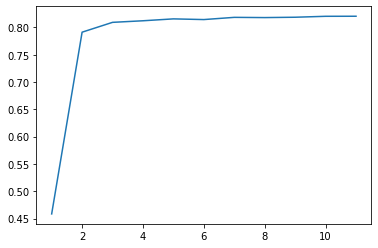

In [4]:
# TESTING
# creating Modelcheckpoint
checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_auc', 
                                                 verbose=1,
                                                 save_best_only=False, 
                                                 save_weights_only=True,
                                                 mode='max',
                                                 save_freq='epoch')


# creating model
epochs = 10
lr = .0001
metrics = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                          keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# saving weights for checkpoints
model.save_weights(checkpoint_path.format(epoch=0))


# fitting model
model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
          batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
          use_multiprocessing=True,
          callbacks=[cp_callback])


# now that all epochs have completed, we will test load and test each weight. 
# parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# a list of all model weights to parse through for testing results against the test set. 
checkpoint_path = './cp.ckpt.testing2/'
list_checkpoints = []
for file in os.listdir(checkpoint_path):
    val_checkpoint = file[0:12]
    if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
        list_checkpoints.append(val_checkpoint)
list_checkpoints.sort()


# parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
filepath_checkpoint_folder = './cp.ckpt.testing2/'
list_auc_score = []
list_epoch = []
val_epoch = 0

for chkpt in list_checkpoints:
    filepath_chkpt = filepath_checkpoint_folder + chkpt

    model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                              keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dropout(.5),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

    
    model.load_weights(filepath_chkpt)
    predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
    rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
    fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
    auc_score = auc(fpr, tpr)
    list_auc_score.append(auc_score)
    val_epoch = val_epoch + 1
    print('epoch:', val_epoch, 'auc_score:', auc_score)    
    cm = confusion_matrix(test_labels, rounded_predictions)
    
list_epoch = []
for val in range(1,len(list_auc_score) + 1):
    list_epoch.append(val)
    
plt.plot(list_epoch, list_auc_score)

Train on 190000 samples, validate on 11811 samples
Epoch 1/10



Epoch 00001: saving model to ./cp.ckpt.testing2/cp-0001.ckpt
190000/190000 - 29s - loss: 0.5255 - auc: 0.8250 - fp: 22763.0000 - fn: 24991.0000 - val_loss: 0.3992 - val_auc: 0.8742 - val_fp: 1773.0000 - val_fn: 98.0000
Epoch 2/10

Epoch 00002: saving model to ./cp.ckpt.testing2/cp-0002.ckpt
190000/190000 - 28s - loss: 0.4320 - auc: 0.8872 - fp: 16614.0000 - fn: 19271.0000 - val_loss: 0.3712 - val_auc: 0.8895 - val_fp: 1699.0000 - val_fn: 85.0000
Epoch 3/10

Epoch 00003: saving model to ./cp.ckpt.testing2/cp-0003.ckpt
190000/190000 - 29s - loss: 0.4026 - auc: 0.9031 - fp: 15408.0000 - fn: 17458.0000 - val_loss: 0.3447 - val_auc: 0.8960 - val_fp: 1511.0000 - val_fn: 93.0000
Epoch 4/10

Epoch 00004: saving model to ./cp.ckpt.testing2/cp-0004.ckpt
190000/190000 - 30s - loss: 0.3814 - auc: 0.9144 - fp: 14342.0000 - fn: 16137.0000 - val_loss: 0.3116 - val_auc: 0.9007 - val_fp: 1344.0000 - val_fn: 102.0000


Epoch 5/10

Epoch 00005: saving model to ./cp.ckpt.testing2/cp-0005.ckpt
190000/190000 - 31s - loss: 0.3647 - auc: 0.9223 - fp: 13610.0000 - fn: 14930.0000 - val_loss: 0.3129 - val_auc: 0.9048 - val_fp: 1350.0000 - val_fn: 95.0000
Epoch 6/10

Epoch 00006: saving model to ./cp.ckpt.testing2/cp-0006.ckpt
190000/190000 - 34s - loss: 0.3508 - auc: 0.9286 - fp: 13106.0000 - fn: 13969.0000 - val_loss: 0.2959 - val_auc: 0.9045 - val_fp: 1284.0000 - val_fn: 96.0000
Epoch 7/10

Epoch 00007: saving model to ./cp.ckpt.testing2/cp-0007.ckpt
190000/190000 - 31s - loss: 0.3385 - auc: 0.9337 - fp: 12553.0000 - fn: 13223.0000 - val_loss: 0.2849 - val_auc: 0.9051 - val_fp: 1209.0000 - val_fn: 102.0000
Epoch 8/10

Epoch 00008: saving model to ./cp.ckpt.testing2/cp-0008.ckpt
190000/190000 - 26s - loss: 0.3276 - auc: 0.9380 - fp: 12166.0000 - fn: 12817.0000 - val_loss: 0.2650 - val_auc: 0.9052 - val_fp: 1117.0000 - val_fn: 97.0000
Epoch 9/10

Epoch 00009: saving model to ./cp.ckpt.testing2/cp-0009.ckpt
19

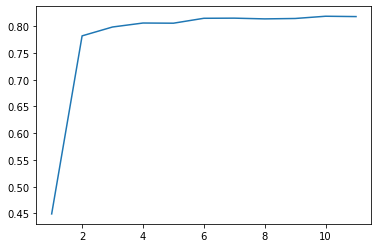

In [5]:
# TESTING
# creating Modelcheckpoint
checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_auc', 
                                                 verbose=1,
                                                 save_best_only=False, 
                                                 save_weights_only=True,
                                                 mode='max',
                                                 save_freq='epoch')


# creating model
epochs = 10
lr = .0001
metrics = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                          keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
                                             bias_regularizer=l2(0.0001),
#                                              activity_regularizer=l2(0.0001),
#                                              kernel_constraint=l2(0.0001),
#                                              bias_constraint=l2(0.0001)
                                            ),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# saving weights for checkpoints
model.save_weights(checkpoint_path.format(epoch=0))


# fitting model
model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
          batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
          use_multiprocessing=True,
          callbacks=[cp_callback])


# now that all epochs have completed, we will test load and test each weight. 
# parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# a list of all model weights to parse through for testing results against the test set. 
checkpoint_path = './cp.ckpt.testing2/'
list_checkpoints = []
for file in os.listdir(checkpoint_path):
    val_checkpoint = file[0:12]
    if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
        list_checkpoints.append(val_checkpoint)
list_checkpoints.sort()


# parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
filepath_checkpoint_folder = './cp.ckpt.testing2/'
list_auc_score = []
list_epoch = []
val_epoch = 0

for chkpt in list_checkpoints:
    filepath_chkpt = filepath_checkpoint_folder + chkpt

    model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                              keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),bias_regularizer=l2(0.0001)),
                              keras.layers.Dropout(.5),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])


    
    model.load_weights(filepath_chkpt)
    predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
    rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
    fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
    auc_score = auc(fpr, tpr)
    list_auc_score.append(auc_score)
    val_epoch = val_epoch + 1
    print('epoch:', val_epoch, 'auc_score:', auc_score)    
    cm = confusion_matrix(test_labels, rounded_predictions)
    
list_epoch = []
for val in range(1,len(list_auc_score) + 1):
    list_epoch.append(val)
    
plt.plot(list_epoch, list_auc_score)

Train on 190000 samples, validate on 11811 samples
Epoch 1/55

Epoch 00001: saving model to ./cp.ckpt.testing2/cp-0001.ckpt
190000/190000 - 36s - loss: 0.5147 - auc: 0.8325 - fp: 21292.0000 - fn: 25786.0000 - val_loss: 0.4015 - val_auc: 0.8736 - val_fp: 1685.0000 - val_fn: 95.0000
Epoch 2/55

Epoch 00002: saving model to ./cp.ckpt.testing2/cp-0002.ckpt
190000/190000 - 29s - loss: 0.4299 - auc: 0.8886 - fp: 15127.0000 - fn: 20555.0000 - val_loss: 0.3647 - val_auc: 0.8866 - val_fp: 1501.0000 - val_fn: 98.0000
Epoch 3/55

Epoch 00003: saving model to ./cp.ckpt.testing2/cp-0003.ckpt
190000/190000 - 31s - loss: 0.4026 - auc: 0.9038 - fp: 14008.0000 - fn: 18733.0000 - val_loss: 0.3615 - val_auc: 0.8940 - val_fp: 1525.0000 - val_fn: 94.0000


Epoch 4/55

Epoch 00004: saving model to ./cp.ckpt.testing2/cp-0004.ckpt
190000/190000 - 30s - loss: 0.3832 - auc: 0.9136 - fp: 13392.0000 - fn: 17240.0000 - val_loss: 0.3330 - val_auc: 0.8982 - val_fp: 1439.0000 - val_fn: 96.0000
Epoch 5/55

Epoch 00005: saving model to ./cp.ckpt.testing2/cp-0005.ckpt
190000/190000 - 28s - loss: 0.3668 - auc: 0.9215 - fp: 12692.0000 - fn: 15985.0000 - val_loss: 0.3081 - val_auc: 0.9020 - val_fp: 1301.0000 - val_fn: 100.0000
Epoch 6/55

Epoch 00006: saving model to ./cp.ckpt.testing2/cp-0006.ckpt
190000/190000 - 27s - loss: 0.3504 - auc: 0.9289 - fp: 11910.0000 - fn: 14927.0000 - val_loss: 0.3102 - val_auc: 0.9046 - val_fp: 1326.0000 - val_fn: 99.0000
Epoch 7/55

Epoch 00007: saving model to ./cp.ckpt.testing2/cp-0007.ckpt
190000/190000 - 31s - loss: 0.3390 - auc: 0.9336 - fp: 11680.0000 - fn: 13968.0000 - val_loss: 0.2878 - val_auc: 0.9047 - val_fp: 1196.0000 - val_fn: 107.0000
Epoch 8/55

Epoch 00008: saving model to ./cp.ckpt.testing2/cp-0008.ckpt
1

Epoch 40/55

Epoch 00040: saving model to ./cp.ckpt.testing2/cp-0040.ckpt
190000/190000 - 27s - loss: 0.2494 - auc: 0.9638 - fp: 6775.0000 - fn: 10942.0000 - val_loss: 0.2560 - val_auc: 0.9131 - val_fp: 972.0000 - val_fn: 107.0000
Epoch 41/55

Epoch 00041: saving model to ./cp.ckpt.testing2/cp-0041.ckpt
190000/190000 - 28s - loss: 0.2489 - auc: 0.9639 - fp: 6899.0000 - fn: 10802.0000 - val_loss: 0.2402 - val_auc: 0.9085 - val_fp: 841.0000 - val_fn: 112.0000
Epoch 42/55

Epoch 00042: saving model to ./cp.ckpt.testing2/cp-0042.ckpt
190000/190000 - 26s - loss: 0.2475 - auc: 0.9643 - fp: 6746.0000 - fn: 10907.0000 - val_loss: 0.2270 - val_auc: 0.9081 - val_fp: 756.0000 - val_fn: 120.0000
Epoch 43/55

Epoch 00043: saving model to ./cp.ckpt.testing2/cp-0043.ckpt
190000/190000 - 26s - loss: 0.2479 - auc: 0.9642 - fp: 6724.0000 - fn: 10811.0000 - val_loss: 0.2222 - val_auc: 0.9163 - val_fp: 774.0000 - val_fn: 113.0000
Epoch 44/55

Epoch 00044: saving model to ./cp.ckpt.testing2/cp-0044.ckpt
19

epoch: 16 auc_score: 0.8173865335166365
epoch: 17 auc_score: 0.81708234789881
epoch: 18 auc_score: 0.8193319366402673
epoch: 19 auc_score: 0.816550832174795
epoch: 20 auc_score: 0.8144761266317854
epoch: 21 auc_score: 0.8170530395223392
epoch: 22 auc_score: 0.817187634985511
epoch: 23 auc_score: 0.8149250102701813
epoch: 24 auc_score: 0.814304086590844
epoch: 25 auc_score: 0.8158708984712968
epoch: 26 auc_score: 0.8127600199704414
epoch: 27 auc_score: 0.8145740640596266
epoch: 28 auc_score: 0.8156545477239138
epoch: 29 auc_score: 0.8093860301294752
epoch: 30 auc_score: 0.8140222529618482
epoch: 31 auc_score: 0.8086068889255082
epoch: 32 auc_score: 0.818392128025384
epoch: 33 auc_score: 0.8205383960362387
epoch: 34 auc_score: 0.8164169329950943
epoch: 35 auc_score: 0.8131344979834856
epoch: 36 auc_score: 0.8159570699978931
epoch: 37 auc_score: 0.8138103184568501
epoch: 38 auc_score: 0.8126318973647219
epoch: 39 auc_score: 0.8124732865688723
epoch: 40 auc_score: 0.8106880673259697
epoch:

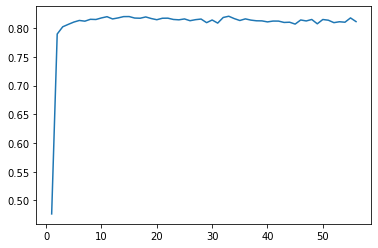

In [13]:
# TESTING
# creating Modelcheckpoint
checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_auc', 
                                                 verbose=1,
                                                 save_best_only=False, 
                                                 save_weights_only=True,
                                                 mode='max',
                                                 save_freq='epoch')


# creating model
epochs = 55
lr = .0001
metrics = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                          keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
                                             bias_regularizer=l2(0.0001),
                                             activity_regularizer=l2(0.0001),
#                                              kernel_constraint=l2(0.0001),
#                                              bias_constraint=l2(0.0001)
                                            ),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# saving weights for checkpoints
model.save_weights(checkpoint_path.format(epoch=0))


# fitting model
model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
          batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
          use_multiprocessing=True,
          callbacks=[cp_callback])


# now that all epochs have completed, we will test load and test each weight. 
# parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# a list of all model weights to parse through for testing results against the test set. 
checkpoint_path = './cp.ckpt.testing2/'
list_checkpoints = []
for file in os.listdir(checkpoint_path):
    val_checkpoint = file[0:12]
    if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
        list_checkpoints.append(val_checkpoint)
list_checkpoints.sort()


# parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
filepath_checkpoint_folder = './cp.ckpt.testing2/'
list_auc_score = []
list_epoch = []
val_epoch = 0

for chkpt in list_checkpoints:
    filepath_chkpt = filepath_checkpoint_folder + chkpt

    model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                          keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
                                             bias_regularizer=l2(0.0001),
                                             activity_regularizer=l2(0.0001),
#                                              kernel_constraint=l2(0.0001),
#                                              bias_constraint=l2(0.0001)
                                            ),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])


    
    model.load_weights(filepath_chkpt)
    predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
    rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
    fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
    auc_score = auc(fpr, tpr)
    list_auc_score.append(auc_score)
    val_epoch = val_epoch + 1
    print('epoch:', val_epoch, 'auc_score:', auc_score)    
    cm = confusion_matrix(test_labels, rounded_predictions)
    
list_epoch = []
for val in range(1,len(list_auc_score) + 1):
    list_epoch.append(val)
    
plt.plot(list_epoch, list_auc_score)

Train on 190000 samples, validate on 11811 samples
Epoch 1/10

Epoch 00001: saving model to ./cp.ckpt.testing2/cp-0001.ckpt
190000/190000 - 34s - loss: 0.5182 - auc: 0.8301 - fp: 23289.0000 - fn: 23787.0000 - val_loss: 0.4145 - val_auc: 0.8796 - val_fp: 1758.0000 - val_fn: 89.0000
Epoch 2/10

Epoch 00002: saving model to ./cp.ckpt.testing2/cp-0002.ckpt
190000/190000 - 30s - loss: 0.4301 - auc: 0.8887 - fp: 14960.0000 - fn: 20251.0000 - val_loss: 0.3686 - val_auc: 0.8910 - val_fp: 1503.0000 - val_fn: 94.0000
Epoch 3/10

Epoch 00003: saving model to ./cp.ckpt.testing2/cp-0003.ckpt
190000/190000 - 30s - loss: 0.4005 - auc: 0.9049 - fp: 13281.0000 - fn: 18464.0000 - val_loss: 0.3244 - val_auc: 0.8917 - val_fp: 1328.0000 - val_fn: 104.0000


Epoch 4/10

Epoch 00004: saving model to ./cp.ckpt.testing2/cp-0004.ckpt
190000/190000 - 29s - loss: 0.3811 - auc: 0.9145 - fp: 12169.0000 - fn: 17408.0000 - val_loss: 0.3536 - val_auc: 0.8992 - val_fp: 1486.0000 - val_fn: 91.0000
Epoch 5/10

Epoch 00005: saving model to ./cp.ckpt.testing2/cp-0005.ckpt
190000/190000 - 38s - loss: 0.3634 - auc: 0.9226 - fp: 11526.0000 - fn: 16407.0000 - val_loss: 0.3137 - val_auc: 0.9000 - val_fp: 1290.0000 - val_fn: 99.0000
Epoch 6/10

Epoch 00006: saving model to ./cp.ckpt.testing2/cp-0006.ckpt
190000/190000 - 29s - loss: 0.3498 - auc: 0.9287 - fp: 10768.0000 - fn: 15906.0000 - val_loss: 0.3052 - val_auc: 0.9039 - val_fp: 1232.0000 - val_fn: 95.0000
Epoch 7/10

Epoch 00007: saving model to ./cp.ckpt.testing2/cp-0007.ckpt
190000/190000 - 31s - loss: 0.3382 - auc: 0.9336 - fp: 10152.0000 - fn: 15577.0000 - val_loss: 0.2964 - val_auc: 0.9023 - val_fp: 1151.0000 - val_fn: 105.0000
Epoch 8/10

Epoch 00008: saving model to ./cp.ckpt.testing2/cp-0008.ckpt
19

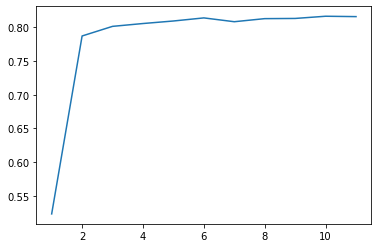

In [8]:
# TESTING
# creating Modelcheckpoint
checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_auc', 
                                                 verbose=1,
                                                 save_best_only=False, 
                                                 save_weights_only=True,
                                                 mode='max',
                                                 save_freq='epoch')


# creating model
epochs = 10
lr = .0001
metrics = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                          keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
                                             bias_regularizer=l2(0.0001),
                                             activity_regularizer=l2(0.0001),
#                                              kernel_constraint=l2(0.0001),
#                                              bias_constraint=l2(0.0001)
                                            ),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# saving weights for checkpoints
model.save_weights(checkpoint_path.format(epoch=0))


# fitting model
model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
          batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
          use_multiprocessing=True,
          callbacks=[cp_callback])


# now that all epochs have completed, we will test load and test each weight. 
# parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# a list of all model weights to parse through for testing results against the test set. 
checkpoint_path = './cp.ckpt.testing2/'
list_checkpoints = []
for file in os.listdir(checkpoint_path):
    val_checkpoint = file[0:12]
    if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
        list_checkpoints.append(val_checkpoint)
list_checkpoints.sort()


# parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
filepath_checkpoint_folder = './cp.ckpt.testing2/'
list_auc_score = []
list_epoch = []
val_epoch = 0

for chkpt in list_checkpoints:
    filepath_chkpt = filepath_checkpoint_folder + chkpt

    model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                          keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
                                             bias_regularizer=l2(0.0001),
                                             activity_regularizer=l2(0.0001),
#                                              kernel_constraint=l2(0.0001),
#                                              bias_constraint=l2(0.0001)
                                            ),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])


    
    model.load_weights(filepath_chkpt)
    predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
    rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
    fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
    auc_score = auc(fpr, tpr)
    list_auc_score.append(auc_score)
    val_epoch = val_epoch + 1
    print('epoch:', val_epoch, 'auc_score:', auc_score)    
    cm = confusion_matrix(test_labels, rounded_predictions)
    
list_epoch = []
for val in range(1,len(list_auc_score) + 1):
    list_epoch.append(val)
    
plt.plot(list_epoch, list_auc_score)

Train on 190000 samples, validate on 11811 samples
Epoch 1/10

Epoch 00001: saving model to ./cp.ckpt.testing2/cp-0001.ckpt
190000/190000 - 30s - loss: 0.5061 - auc: 0.8393 - fp: 21794.0000 - fn: 23783.0000 - val_loss: 0.4001 - val_auc: 0.8713 - val_fp: 1749.0000 - val_fn: 99.0000
Epoch 2/10

Epoch 00004: saving model to ./cp.ckpt.testing2/cp-0004.ckpt
190000/190000 - 27s - loss: 0.3797 - auc: 0.9158 - fp: 14003.0000 - fn: 16097.0000 - val_loss: 0.3370 - val_auc: 0.8997 - val_fp: 1400.0000 - val_fn: 100.0000
Epoch 5/10

Epoch 00005: saving model to ./cp.ckpt.testing2/cp-0005.ckpt
190000/190000 - 27s - loss: 0.3642 - auc: 0.9229 - fp: 13431.0000 - fn: 15016.0000 - val_loss: 0.2974 - val_auc: 0.9036 - val_fp: 1177.0000 - val_fn: 108.0000
Epoch 6/10

Epoch 00006: saving model to ./cp.ckpt.testing2/cp-0006.ckpt
190000/190000 - 32s - loss: 0.3512 - auc: 0.9287 - fp: 12693.0000 - fn: 14383.0000 - val_loss: 0.3084 - val_auc: 0.9075 - val_fp: 1257.0000 - val_fn: 100.0000
Epoch 7/10

Epoch 0000

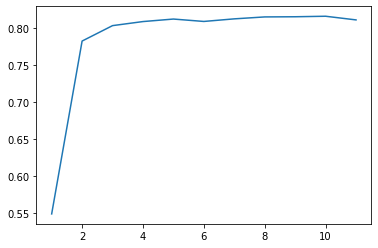

In [11]:
# TESTING
# creating Modelcheckpoint
checkpoint_path = "./cp.ckpt.testing2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_auc', 
                                                 verbose=1,
                                                 save_best_only=False, 
                                                 save_weights_only=True,
                                                 mode='max',
                                                 save_freq='epoch')


# creating model
epochs = 10
lr = .0001
metrics = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                          keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
                                             bias_regularizer=l2(0.0001),
                                             activity_regularizer=l2(0.0001),
#                                              kernel_constraint=l2(0.0001),
#                                              bias_constraint=l2(0.0001)
                                            ),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])

# Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
#       bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
#       activity_regularizer=None, kernel_constraint=None, bias_constraint=None
    
model.compile(optimizer=keras.optimizers.Adam(lr=lr), loss=loss, metrics=metrics)


# saving weights for checkpoints
model.save_weights(checkpoint_path.format(epoch=0))


# fitting model
model.fit(scaled_train_samples, train_labels, validation_data=(scaled_val_samples, val_labels), 
          batch_size=20, epochs=epochs, shuffle=True, verbose=2, workers=16, 
          use_multiprocessing=True,
          callbacks=[cp_callback])


# now that all epochs have completed, we will test load and test each weight. 
# parsing through folder with saved weights and selecting unique values with cp-0001 to cp-xxxx to create
# a list of all model weights to parse through for testing results against the test set. 
checkpoint_path = './cp.ckpt.testing2/'
list_checkpoints = []
for file in os.listdir(checkpoint_path):
    val_checkpoint = file[0:12]
    if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
        list_checkpoints.append(val_checkpoint)
list_checkpoints.sort()


# parsing through each saved weights through the list, then loading the weights, scoring and plotting results.
filepath_checkpoint_folder = './cp.ckpt.testing2/'
list_auc_score = []
list_epoch = []
val_epoch = 0

for chkpt in list_checkpoints:
    filepath_chkpt = filepath_checkpoint_folder + chkpt

    model = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(train_samples.shape[-1],)),
                          keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001),
                                             bias_regularizer=l2(0.0001),
                                             activity_regularizer=l2(0.0001),
#                                              kernel_constraint=l2(0.0001),
#                                              bias_constraint=l2(0.0001)
                                            ),
                          keras.layers.Dropout(.5),
                          keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])


    
    model.load_weights(filepath_chkpt)
    predictions = model.predict(scaled_test_samples, batch_size=10, verbose=0)
    rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10, verbose=0)
    fpr, tpr, thresholds = roc_curve(test_labels, rounded_predictions, pos_label=1)
    auc_score = auc(fpr, tpr)
    list_auc_score.append(auc_score)
    val_epoch = val_epoch + 1
    print('epoch:', val_epoch, 'auc_score:', auc_score)    
    cm = confusion_matrix(test_labels, rounded_predictions)
    
list_epoch = []
for val in range(1,len(list_auc_score) + 1):
    list_epoch.append(val)
    
plt.plot(list_epoch, list_auc_score)